Freeze Packages in requirement.txt

!pip freeze > requirement.txt





!pip install -r requirement.txt

In [1]:
!pip install xgboost

In [162]:
!pip install lightgbm

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,boxcox
from outlier import outlier_detection,multi_outlier
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import classification_report,roc_auc_score
from xgboost import XGBClassifier as xgbc
from lightgbm import LGBMClassifier
import lightgbm as lgb
import h5py

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Read Data

In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [5]:
train.head()


id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

In [6]:
test.head()

id Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0  381110   Male   25                1         11.0                   1   
1  381111   Male   40                1         28.0                   0   
2  381112   Male   47                1         28.0                   0   
3  381113   Male   24                1         27.0                   1   
4  381114   Male   27                1         28.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  
0    < 1 Year             No         35786.0                 152.0       53  
1    1-2 Year            Yes         33762.0                   7.0      111  
2    1-2 Year            Yes         40050.0                 124.0      199  
3    < 1 Year            Yes         37356.0                 152.0      187  
4    < 1 Year             No         59097.0                 152.0      297

In [7]:
x=train[~train.iloc[:,1:].duplicated(keep='first')]

In [8]:
x.shape

(380840, 12)

In [9]:
train=train[~train.id.isin(x[x.iloc[:,1:-1].duplicated(keep=False)].id)]

In [10]:
train.shape

(381003, 12)

## Data Discripancy

In [11]:
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [12]:
test.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
dtype: object

**No discripancies in data types**

### Missing Values

In [13]:
train.isna().sum()/train.shape[0]

id                      0.0
Gender                  0.0
Age                     0.0
Driving_License         0.0
Region_Code             0.0
Previously_Insured      0.0
Vehicle_Age             0.0
Vehicle_Damage          0.0
Annual_Premium          0.0
Policy_Sales_Channel    0.0
Vintage                 0.0
Response                0.0
dtype: float64

In [14]:
test.isna().sum()/test.shape[0]

id                      0.0
Gender                  0.0
Age                     0.0
Driving_License         0.0
Region_Code             0.0
Previously_Insured      0.0
Vehicle_Age             0.0
Vehicle_Damage          0.0
Annual_Premium          0.0
Policy_Sales_Channel    0.0
Vintage                 0.0
dtype: float64

### Data Quality Check 

In [15]:
train['Gender'].value_counts()/train.shape[0]

Male      0.540754
Female    0.459246
Name: Gender, dtype: float64

In [16]:
test['Gender'].value_counts()/test.shape[0]

Male      0.537135
Female    0.462865
Name: Gender, dtype: float64

In [17]:
train['Driving_License'].value_counts()/train.shape[0]

1    0.997869
0    0.002131
Name: Driving_License, dtype: float64

In [18]:
test['Driving_License'].value_counts()/test.shape[0]

1    0.998134
0    0.001866
Name: Driving_License, dtype: float64

In [19]:
train['Previously_Insured'].value_counts()/train.shape[0]

0    0.541662
1    0.458338
Name: Previously_Insured, dtype: float64

In [20]:
test['Previously_Insured'].value_counts()/test.shape[0]

0    0.539961
1    0.460039
Name: Previously_Insured, dtype: float64

In [21]:
train['Vehicle_Age'].value_counts()/train.shape[0]

1-2 Year     0.525518
< 1 Year     0.432474
> 2 Years    0.042008
Name: Vehicle_Age, dtype: float64

In [22]:
test['Vehicle_Age'].value_counts()/test.shape[0]

1-2 Year     0.525036
< 1 Year     0.433094
> 2 Years    0.041870
Name: Vehicle_Age, dtype: float64

In [23]:
train['Vehicle_Damage'].value_counts()/train.shape[0]

Yes    0.504739
No     0.495261
Name: Vehicle_Damage, dtype: float64

In [24]:
test['Vehicle_Damage'].value_counts()/test.shape[0]

Yes    0.502491
No     0.497509
Name: Vehicle_Damage, dtype: float64

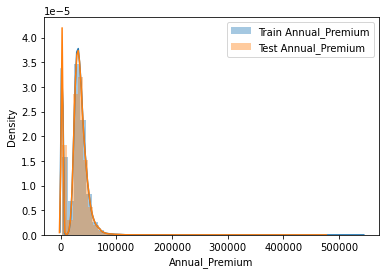

In [25]:
sns.distplot(train['Annual_Premium'],label='Train Annual_Premium')
sns.distplot(test['Annual_Premium'],label='Test Annual_Premium')
plt.legend()

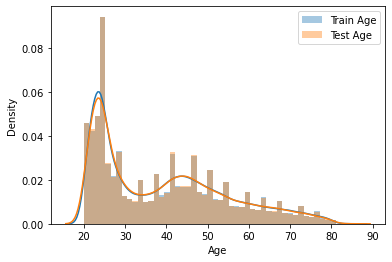

In [26]:
sns.distplot(train['Age'],label='Train Age')
sns.distplot(test['Age'],label='Test Age')
plt.legend()

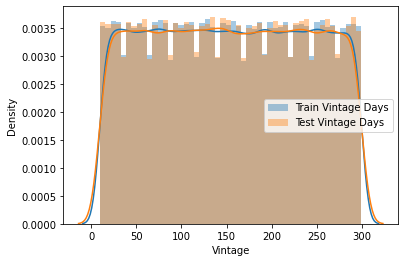

In [27]:
sns.distplot(train['Vintage'],label='Train Vintage Days')
sns.distplot(test['Vintage'],label='Test Vintage Days')
plt.legend()

### Outlier

{'whiskers': [<matplotlib.lines.Line2D at 0x1e61ef04cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1e61ef113d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e61ef04970>],
 'medians': [<matplotlib.lines.Line2D at 0x1e61ef11a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e61ef11df0>],
 'means': []}

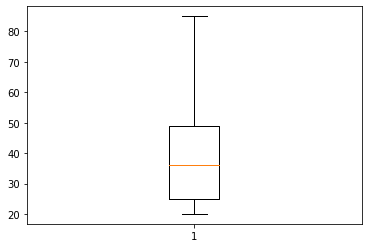

In [28]:
plt.boxplot(train['Age'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1e61ef69820>,
 'caps': [<matplotlib.lines.Line2D at 0x1e61ef69ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e61ef694c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e61ef755e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e61ef75940>],
 'means': []}

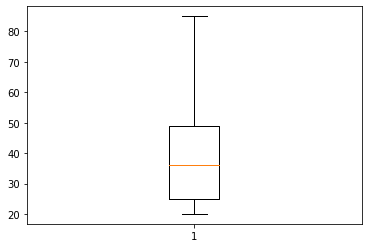

In [29]:
plt.boxplot(test['Age'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1e61efce400>,
 'caps': [<matplotlib.lines.Line2D at 0x1e61efceac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e61efce0a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e61efda1c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e61efda520>],
 'means': []}

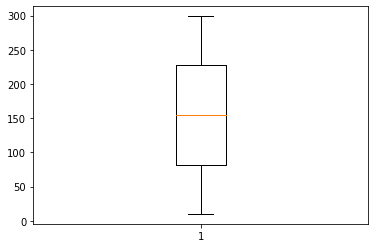

In [30]:
plt.boxplot(train['Vintage'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1e61f063ee0>,
 'caps': [<matplotlib.lines.Line2D at 0x1e61f0725e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e61f063b80>],
 'medians': [<matplotlib.lines.Line2D at 0x1e61f072ca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e61f07f040>],
 'means': []}

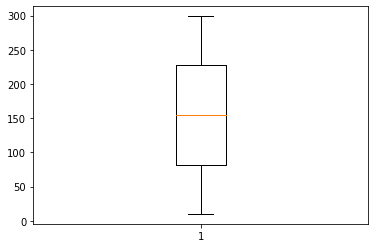

In [31]:
plt.boxplot(test['Vintage'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1e61f0c9a30>,
 'caps': [<matplotlib.lines.Line2D at 0x1e61f0d6130>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e61f0c96d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e61f0d67f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e61f0d6b50>],
 'means': []}

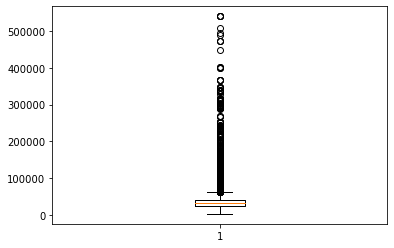

In [32]:
plt.boxplot(train['Annual_Premium'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1e61f130070>,
 'caps': [<matplotlib.lines.Line2D at 0x1e61f130730>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e61f120cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e61f130df0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e61f13e190>],
 'means': []}

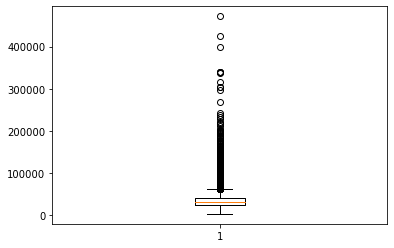

In [33]:
plt.boxplot(test['Annual_Premium'])

In [34]:
outlier_detection(df=train,col='Annual_Premium')

{'whiskers': [<matplotlib.lines.Line2D at 0x1e61f18f340>,
 'caps': [<matplotlib.lines.Line2D at 0x1e61f18fa00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e61f180fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e61f19b100>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e61f19b460>],
 'means': []}

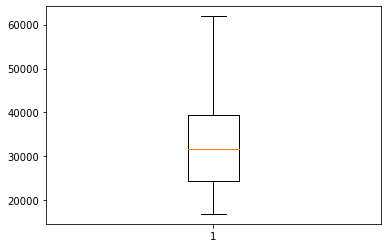

In [35]:
plt.boxplot(train['Annual_Premium'])

In [36]:
outlier_detection(df=test,col='Annual_Premium')

{'whiskers': [<matplotlib.lines.Line2D at 0x1e61f1eb550>,
 'caps': [<matplotlib.lines.Line2D at 0x1e61f1ebc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e61f1eb1f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e61f1f6310>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e61f1f6670>],
 'means': []}

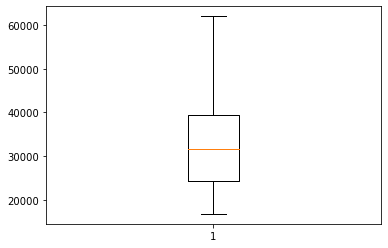

In [37]:
plt.boxplot(test['Annual_Premium'])

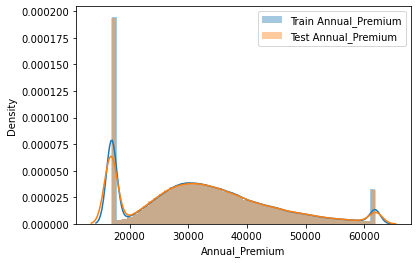

In [38]:
sns.distplot(train['Annual_Premium'],label='Train Annual_Premium')
sns.distplot(test['Annual_Premium'],label='Test Annual_Premium')
plt.legend()

## Explore Data

In [39]:
pd.crosstab(train['Gender'],train['Response'],normalize=True).sort_values(by=[1],ascending=False)

Response         0         1
Gender                      
Male      0.465965  0.074789
Female    0.411577  0.047669

In [40]:
pd.crosstab(train['Driving_License'],train['Response'],normalize=True).sort_values(by=[1],ascending=False)

Response                0         1
Driving_License                    
1                0.875518  0.122351
0                0.002024  0.000108

In [41]:
pd.crosstab(train['Previously_Insured'],train['Response'],normalize=True).sort_values(by=[1],ascending=False)

Response                   0         1
Previously_Insured                    
0                   0.419619  0.122044
1                   0.457923  0.000415

In [42]:
pd.crosstab(train['Vehicle_Age'],train['Response'],normalize=True).sort_values(by=[1],ascending=False)

Response            0         1
Vehicle_Age                    
1-2 Year     0.434285  0.091233
< 1 Year     0.413587  0.018887
> 2 Years    0.029669  0.012338

In [43]:
pd.crosstab(train['Vehicle_Damage'],train['Response'],normalize=True).sort_values(by=[1],ascending=False)

Response               0         1
Vehicle_Damage                    
Yes             0.384858  0.119881
No              0.492684  0.002577

In [44]:
pd.crosstab(train['Gender'],train['Response'],values=train['Vintage'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response           0           1
Gender                          
Male      154.126978  154.297947
Female    154.667564  153.825184

In [45]:
pd.crosstab(train['Driving_License'],train['Response'],values=train['Vintage'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response                  0           1
Driving_License                        
1                154.375568  154.122941
0                156.522698  143.853659

In [46]:
pd.crosstab(train['Previously_Insured'],train['Response'],values=train['Vintage'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response                     0           1
Previously_Insured                        
1                   154.576684  156.253165
0                   154.166448  154.106647

In [47]:
pd.crosstab(train['Vehicle_Age'],train['Response'],values=train['Vintage'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response              0           1
Vehicle_Age                        
> 2 Years    154.294321  155.281429
1-2 Year     154.128306  154.173130
< 1 Year     154.651538  153.065175

In [48]:
pd.crosstab(train['Vehicle_Damage'],train['Response'],values=train['Vintage'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response                 0           1
Vehicle_Damage                        
Yes             154.188738  154.140120
No              154.530328  152.895112

In [49]:
pd.crosstab(train['Gender'],train['Response'],values=train['Annual_Premium'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response             0             1
Gender                              
Male      32614.390553  33714.158080
Female    32235.864108  33637.898745

In [50]:
pd.crosstab(train['Driving_License'],train['Response'],values=train['Annual_Premium'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response                    0             1
Driving_License                            
0                36583.161479  35228.878049
1                32427.273979  33683.114542

In [51]:
pd.crosstab(train['Previously_Insured'],train['Response'],values=train['Annual_Premium'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response                       0             1
Previously_Insured                            
0                   32696.628396  33697.113648
1                   32198.815690  29964.329114

In [52]:
pd.crosstab(train['Vehicle_Age'],train['Response'],values=train['Annual_Premium'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response                0             1
Vehicle_Age                            
> 2 Years    36563.751371  39165.487024
1-2 Year     32958.866853  33318.528165
< 1 Year     31592.677560  31871.520011

In [53]:
pd.crosstab(train['Vehicle_Damage'],train['Response'],values=train['Annual_Premium'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response                   0             1
Vehicle_Damage                            
Yes             32875.150561  33800.075008
No              32094.486602  28307.561609

In [54]:
pd.crosstab(train['Vehicle_Damage'],train['Response'],values=train['Age'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response                0          1
Vehicle_Damage                      
Yes             42.725026  43.596081
No              34.625031  35.969450

In [55]:
pd.crosstab(train['Vehicle_Age'],train['Response'],values=train['Age'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response             0          1
Vehicle_Age                      
> 2 Years    56.046975  53.070198
1-2 Year     49.762595  45.572440
< 1 Year     24.730521  26.819344

In [56]:
pd.crosstab(train['Previously_Insured'],train['Response'],values=train['Age'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response                    0          1
Previously_Insured                      
0                   42.162338  43.461859
1                   34.525781  35.696203

In [57]:
pd.crosstab(train['Driving_License'],train['Response'],values=train['Age'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response                 0          1
Driving_License                      
0                65.952010  59.073171
1                38.113198  43.421808

In [58]:
pd.crosstab(train['Gender'],train['Response'],values=train['Age'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response          0          1
Gender                        
Male      40.372746  44.200632
Female    35.691937  42.235216

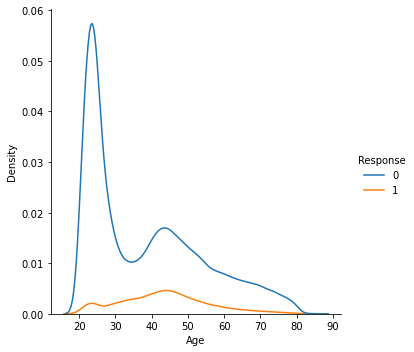

In [59]:
sns.displot(data=train,x='Age',kind='kde',hue='Response')

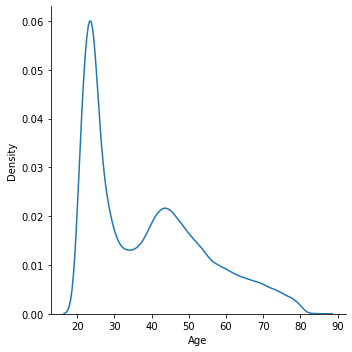

In [60]:
sns.displot(data=train,x='Age',kind='kde')

In [61]:
fitted_data,_=boxcox(train['Age'])
test_fitted_data,_=boxcox(test['Age'])
train.loc[:,'Age']=fitted_data
test.loc[:,'Age']=test_fitted_data

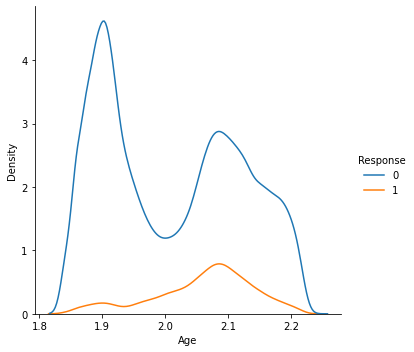

In [62]:
sns.displot(data=train,x='Age',kind='kde',hue='Response')

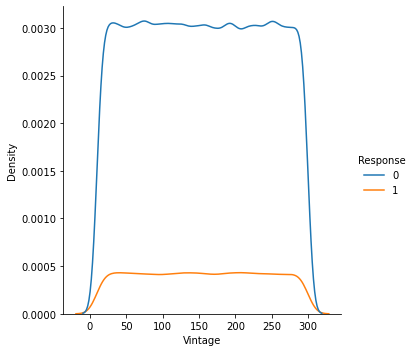

In [63]:
sns.displot(data=train,x='Vintage',kind='kde',hue='Response')

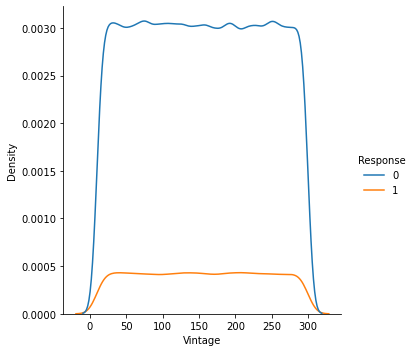

In [64]:
sns.displot(data=train,x='Vintage',kind='kde',hue="Response")

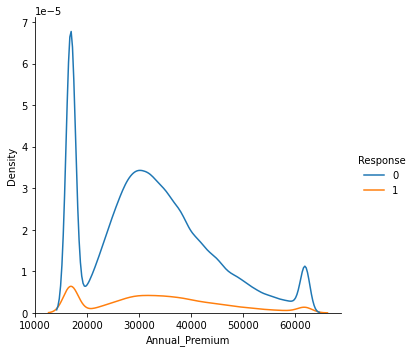

In [65]:
sns.displot(data=train,x='Annual_Premium',kind='kde',hue="Response")

In [66]:
train['Annual_Premium'].skew()

0.5423842474736756

In [67]:
fitted_data,_=boxcox(train['Annual_Premium'])

In [68]:
fitted_data,_=boxcox(train['Annual_Premium'])
fitted_data=pd.DataFrame(fitted_data)

In [69]:
test_fitted_data,_=boxcox(test['Annual_Premium'])
train.loc[:,'Annual_Premium']=np.asarray(fitted_data)
test.loc[:,'Annual_Premium']=np.asarray(test_fitted_data)

<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

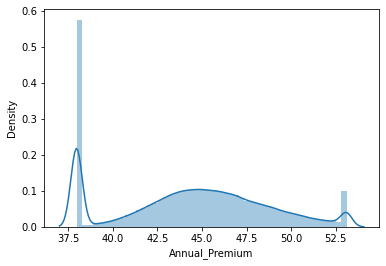

In [70]:
sns.distplot(train['Annual_Premium'])

In [71]:
train.head()

id  Gender       Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male  2.079193                1         28.0                   0   
1   2    Male  2.208392                1          3.0                   0   
2   3    Male  2.096151                1         28.0                   0   
3   4    Male  1.859090                1         11.0                   1   
4   5  Female  1.962292                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes       47.628721                  26.0      217   
1    1-2 Year             No       45.381535                  26.0      183   
2   > 2 Years            Yes       46.960906                  26.0       27   
3    < 1 Year             No       43.557921                 152.0      203   
4    < 1 Year             No       43.108192                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

<AxesSubplot:xlabel='Driving_License', ylabel='Age'>

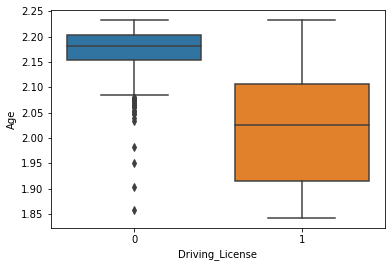

In [72]:
sns.boxplot(x=train['Driving_License'],y=train['Age'])

In [73]:
train=multi_outlier(condition=0,df=train,on_Col='Driving_License',out_Col='Age')

<AxesSubplot:xlabel='Driving_License', ylabel='Age'>

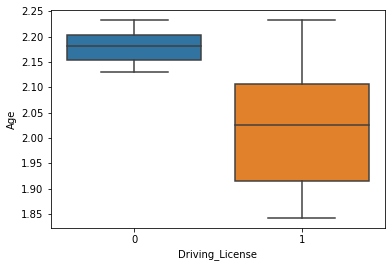

In [74]:
sns.boxplot(x=train['Driving_License'],y=train['Age'])

<AxesSubplot:xlabel='Vehicle_Age', ylabel='Age'>

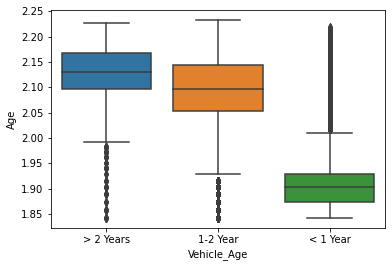

In [75]:
sns.boxplot(x=train['Vehicle_Age'],y=train['Age'])

In [76]:
train=multi_outlier(condition='> 2 Years',df=train,on_Col='Vehicle_Age',out_Col='Age')

In [77]:
train.shape

(381003, 12)

<AxesSubplot:xlabel='Vehicle_Age', ylabel='Age'>

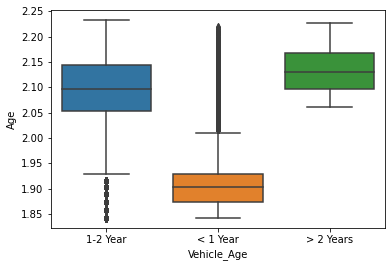

In [78]:
sns.boxplot(x=train['Vehicle_Age'],y=train['Age'])

In [79]:
train=multi_outlier(condition='1-2 Year',df=train,on_Col='Vehicle_Age',out_Col='Age')
train=multi_outlier(condition='< 1 Year',df=train,on_Col='Vehicle_Age',out_Col='Age')

In [80]:
train.shape

(381003, 12)

<AxesSubplot:xlabel='Vehicle_Age', ylabel='Age'>

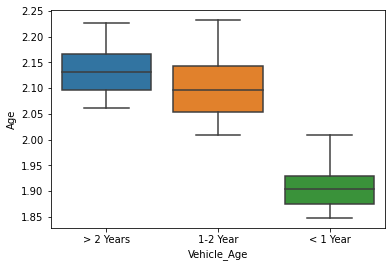

In [81]:
sns.boxplot(x=train['Vehicle_Age'],y=train['Age'])

<AxesSubplot:xlabel='Vehicle_Damage', ylabel='Age'>

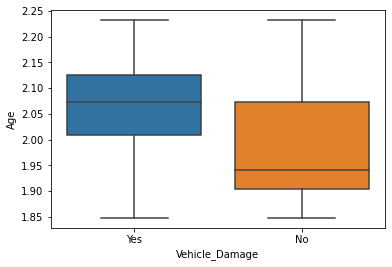

In [82]:
sns.boxplot(x=train['Vehicle_Damage'],y=train['Age'])

<AxesSubplot:xlabel='Gender', ylabel='Annual_Premium'>

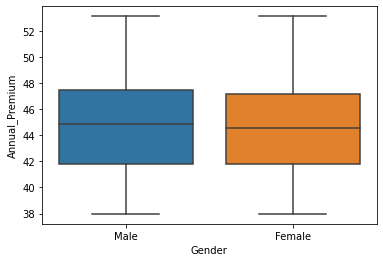

In [83]:
sns.boxplot(x=train['Gender'],y=train['Annual_Premium'])

<AxesSubplot:xlabel='Driving_License', ylabel='Annual_Premium'>

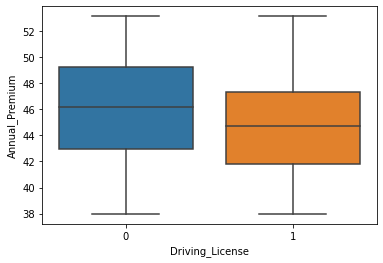

In [84]:
sns.boxplot(x=train['Driving_License'],y=train['Annual_Premium'])

<AxesSubplot:xlabel='Vehicle_Age', ylabel='Annual_Premium'>

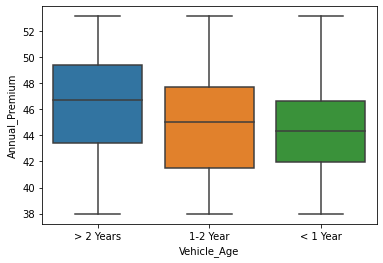

In [85]:
sns.boxplot(x=train['Vehicle_Age'],y=train['Annual_Premium'])

<AxesSubplot:xlabel='Vehicle_Damage', ylabel='Annual_Premium'>

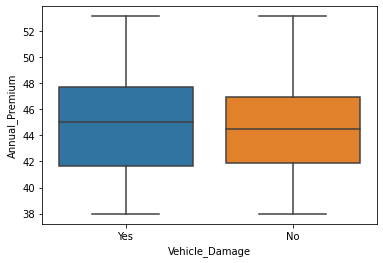

In [86]:
sns.boxplot(x=train['Vehicle_Damage'],y=train['Annual_Premium'])

<AxesSubplot:xlabel='Gender', ylabel='Vintage'>

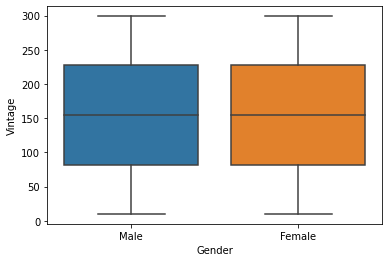

In [87]:
sns.boxplot(x=train['Gender'],y=train['Vintage'])

<AxesSubplot:xlabel='Driving_License', ylabel='Vintage'>

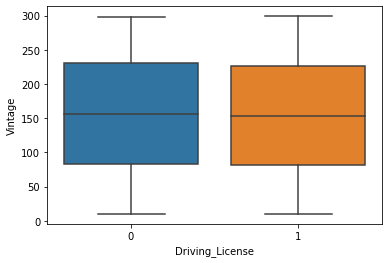

In [88]:
sns.boxplot(x=train['Driving_License'],y=train['Vintage'])

<AxesSubplot:xlabel='Vehicle_Age', ylabel='Vintage'>

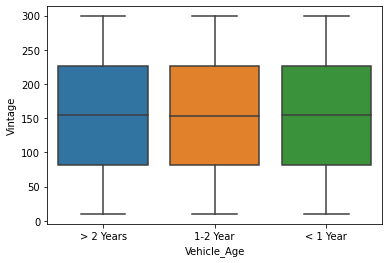

In [89]:
sns.boxplot(x=train['Vehicle_Age'],y=train['Vintage'])

<AxesSubplot:xlabel='Vehicle_Damage', ylabel='Vintage'>

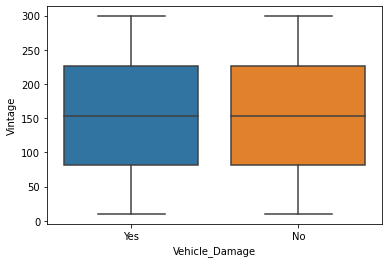

In [90]:
sns.boxplot(x=train['Vehicle_Damage'],y=train['Vintage'])

## Feature Extraction

In [91]:
train['Vehicle_Damage'].replace({'Yes':1,'No':0},inplace=True)
test['Vehicle_Damage'].replace({'Yes':1,'No':0},inplace=True)

In [92]:
train.shape

(381003, 12)

In [93]:
region_Previously_insured=train.groupby('Region_Code')['Previously_Insured'].agg('sum').to_dict()
t_region_Previously_insured=test.groupby('Region_Code')['Previously_Insured'].agg('sum').to_dict()
train['Region_Total_PInsured_d']=train['Region_Code'].map(region_Previously_insured)
test['Region_Total_PInsured_d']=test['Region_Code'].map(t_region_Previously_insured)
train['Region_Total_PInsured_d']/=train.shape[0]
test['Region_Total_PInsured_d']/=test.shape[0]
region_avg_ap=train.groupby('Region_Code')['Annual_Premium'].agg('mean').to_dict()
t_region_avg_ap=test.groupby('Region_Code')['Annual_Premium'].agg('mean').to_dict()
train['Region_Avg_Premium_d']=train['Region_Code'].map(region_avg_ap)
test['Region_Avg_Premium_d']=test['Region_Code'].map(t_region_avg_ap)
region_with_dl=train.groupby('Region_Code')['Driving_License'].agg('sum').to_dict()
t_region_with_dl=test.groupby('Region_Code')['Driving_License'].agg('sum').to_dict()
train['Region_With_DL_d']=train['Region_Code'].map(region_with_dl)
test['Region_With_DL_d']=test['Region_Code'].map(t_region_with_dl)
train['Region_With_DL_d']/=train.shape[0]
test['Region_With_DL_d']/=test.shape[0]
region_damaged_vehicle=train.groupby('Region_Code')['Vehicle_Damage'].agg('sum').to_dict()
t_region_damaged_vehicle=test.groupby('Region_Code')['Vehicle_Damage'].agg('sum').to_dict()
train['Region_Total_Damaged_Vehicle_d']=train['Region_Code'].map(region_damaged_vehicle)
test['Region_Total_Damaged_Vehicle_d']=test['Region_Code'].map(t_region_damaged_vehicle)
train['Region_Total_Damaged_Vehicle_d']/=train.shape[0]
test['Region_Total_Damaged_Vehicle_d']/=test.shape[0]
region_avg_age=train.groupby('Region_Code')['Age'].agg('mean')
t_region_avg_age=test.groupby('Region_Code')['Age'].agg('mean')
train['Region_Avg_Age_d']=train['Region_Code'].map(region_avg_age)
test['Region_Avg_Age_d']=test['Region_Code'].map(t_region_avg_age)

In [94]:
train.shape

(381003, 17)

In [95]:
channel_Previously_insured=train.groupby('Policy_Sales_Channel')['Previously_Insured'].agg('sum').to_dict()
t_channel_Previously_insured=test.groupby('Policy_Sales_Channel')['Previously_Insured'].agg('sum').to_dict()
train['Channel_Total_PInsured_d']=train['Policy_Sales_Channel'].map(channel_Previously_insured)
test['Channel_Total_PInsured_d']=test['Policy_Sales_Channel'].map(t_channel_Previously_insured)
train['Channel_Total_PInsured_d']/=train.shape[0]
test['Channel_Total_PInsured_d']/=test.shape[0]
channel_avg_ap=train.groupby('Policy_Sales_Channel')['Annual_Premium'].agg('mean').to_dict()
t_channel_avg_ap=test.groupby('Policy_Sales_Channel')['Annual_Premium'].agg('mean').to_dict()
train['Channel_Avg_Premium_d']=train['Policy_Sales_Channel'].map(channel_avg_ap)
test['Channel_Avg_Premium_d']=test['Policy_Sales_Channel'].map(t_channel_avg_ap)
channel_with_dl=train.groupby('Policy_Sales_Channel')['Driving_License'].agg('sum').to_dict()
t_channel_with_dl=test.groupby('Policy_Sales_Channel')['Driving_License'].agg('sum').to_dict()
train['Channel_With_DL_d']=train['Policy_Sales_Channel'].map(channel_with_dl)
test['Channel_With_DL_d']=test['Policy_Sales_Channel'].map(t_channel_with_dl)
train['Channel_With_DL_d']/=train.shape[0]
test['Channel_With_DL_d']/=test.shape[0]
channel_damaged_vehicle=train.groupby('Policy_Sales_Channel')['Vehicle_Damage'].agg('sum').to_dict()
t_channel_damaged_vehicle=test.groupby('Policy_Sales_Channel')['Vehicle_Damage'].agg('sum').to_dict()
train['Channel_Total_Damaged_Vehicle_d']=train['Policy_Sales_Channel'].map(channel_damaged_vehicle)
test['Channel_Total_Damaged_Vehicle_d']=test['Policy_Sales_Channel'].map(t_channel_damaged_vehicle)
train['Channel_Total_Damaged_Vehicle_d']/=train.shape[0]
test['Channel_Total_Damaged_Vehicle_d']/=test.shape[0]
channel_avg_age=train.groupby('Policy_Sales_Channel')['Age'].agg('mean')
t_channel_avg_age=test.groupby('Policy_Sales_Channel')['Age'].agg('mean')
train['Channel_Avg_Age_d']=train['Policy_Sales_Channel'].map(channel_avg_age)
test['Channel_Avg_Age_d']=test['Policy_Sales_Channel'].map(t_channel_avg_age)

In [96]:
train.shape

(381003, 22)

In [97]:
train.head()

id  Gender       Age  Driving_License  Region_Code  Previously_Insured  \
0    1    Male  2.079193                1         28.0                   0   
2    3    Male  2.096151                1         28.0                   0   
62  63  Female  2.163173                1         28.0                   0   
86  87  Female  2.130570                1         47.0                   0   
97  98  Female  2.163173                1         28.0                   0   

   Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  ...  \
0    > 2 Years               1       47.628721                  26.0  ...   
2    > 2 Years               1       46.960906                  26.0  ...   
62   > 2 Years               1       45.483927                  26.0  ...   
86   > 2 Years               1       45.148091                  26.0  ...   
97   > 2 Years               1       48.058354                 155.0  ...   

    Region_Total_PInsured_d  Region_Avg_Premium_d  Region_With_DL_d  \
0                  0.087091             46.680532          0.278229   
2                  0.087091             46.680532          0.278229   
62                 0.087091             46.680532          0.278229   
86                 0.008178             44.386286          0.019475   
97                 0.087091             46.680532          0.278229   

    Region_Total_Damaged_Vehicle_d  Region_Avg_Age_d  \
0                         0.184198          2.075401   
2                         0.184198          2.075401   
62                        0.184198          2.075401   
86                        0.010066          1.986620   
97                        0.184198          2.075401   

    Channel_Total_PInsured_d  Channel_Avg_Premium_d  Channel_With_DL_d  \
0                   0.063475              45.368320           0.208025   
2                   0.063475              45.368320           0.208025   
62                  0.063475              45.368320           0.208025   
86                  0.063475              45.368320           0.208025   
97                  0.000472              44.273881           0.003234   

    Channel_Total_Damaged_Vehicle_d  Channel_Avg_Age_d  
0                          0.140881           2.104093  
2                          0.140881           2.104093  
62                         0.140881           2.104093  
86                         0.140881           2.104093  
97                         0.002635           2.064659  

[5 rows x 22 columns]

In [98]:
train.drop(['Region_Code','Policy_Sales_Channel'],axis=1,inplace=True)
test.drop(['Region_Code','Policy_Sales_Channel'],axis=1,inplace=True)

In [99]:
train.shape,test.shape

((381003, 20), (127037, 19))

In [100]:
Response=train[['Response']]
train=train.drop('Response',axis=1)

In [101]:
train.shape

(381003, 19)

## Data Preprocessing

In [102]:
train.shape

(381003, 19)

In [103]:
train['Gender'].replace({'Male':1,'Female':0},inplace=True)
test['Gender'].replace({'Male':1,'Female':0},inplace=True)

In [104]:
train.Vehicle_Age.unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [105]:
train['Vehicle_Age'].replace({'> 2 Years':2,'1-2 Year':1,'< 1 Year':0},inplace=True)
test['Vehicle_Age'].replace({'> 2 Years':2,'1-2 Year':1,'< 1 Year':0},inplace=True)

In [106]:
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

In [107]:
train.columns

Index(['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',
       'Vehicle_Damage', 'Annual_Premium', 'Vintage',
       'Region_Total_PInsured_d', 'Region_Avg_Premium_d', 'Region_With_DL_d',
       'Region_Total_Damaged_Vehicle_d', 'Region_Avg_Age_d',
       'Channel_Total_PInsured_d', 'Channel_Avg_Premium_d',
       'Channel_With_DL_d', 'Channel_Total_Damaged_Vehicle_d',
       'Channel_Avg_Age_d'],
      dtype='object')

In [108]:
cols=['Age','Annual_Premium','Vintage','Region_Total_PInsured_d', 'Region_Avg_Premium_d', 'Region_With_DL_d',
       'Region_Total_Damaged_Vehicle_d', 'Region_Avg_Age_d',
       'Channel_Total_PInsured_d', 'Channel_Avg_Premium_d',
       'Channel_With_DL_d', 'Channel_Total_Damaged_Vehicle_d',
       'Channel_Avg_Age_d']

In [109]:
num_data=train.loc[:,cols]


In [110]:
t_num_data=test.loc[:,cols]

In [111]:
norm=Normalizer().fit(num_data)
num_data=pd.DataFrame(norm.transform(num_data),columns=cols)
t_num_data=pd.DataFrame(norm.transform(t_num_data),columns=cols)

In [112]:
train.shape

(381003, 18)

In [113]:
train.drop(cols,axis=1,inplace=True)
test.drop(cols,axis=1,inplace=True)

In [114]:
train.reset_index(drop=True,inplace=True)

In [115]:
num_data.reset_index(drop=True,inplace=True)

In [116]:
train.head()

Gender  Driving_License  Previously_Insured  Vehicle_Age  Vehicle_Damage
0       1                1                   0            2               1
1       1                1                   0            2               1
2       0                1                   0            2               1
3       0                1                   0            2               1
4       0                1                   0            2               1

In [117]:
train=pd.concat([num_data,train],axis=1)
test=pd.concat([t_num_data,test],axis=1)

In [118]:
train.shape,Response.shape

((381003, 18), (381003, 1))

In [119]:
X_train,X_val,y_train,y_val=tts(train,Response,test_size=.40,random_state=100)

In [120]:
train_data=pd.concat([X_train,y_train],axis=1)

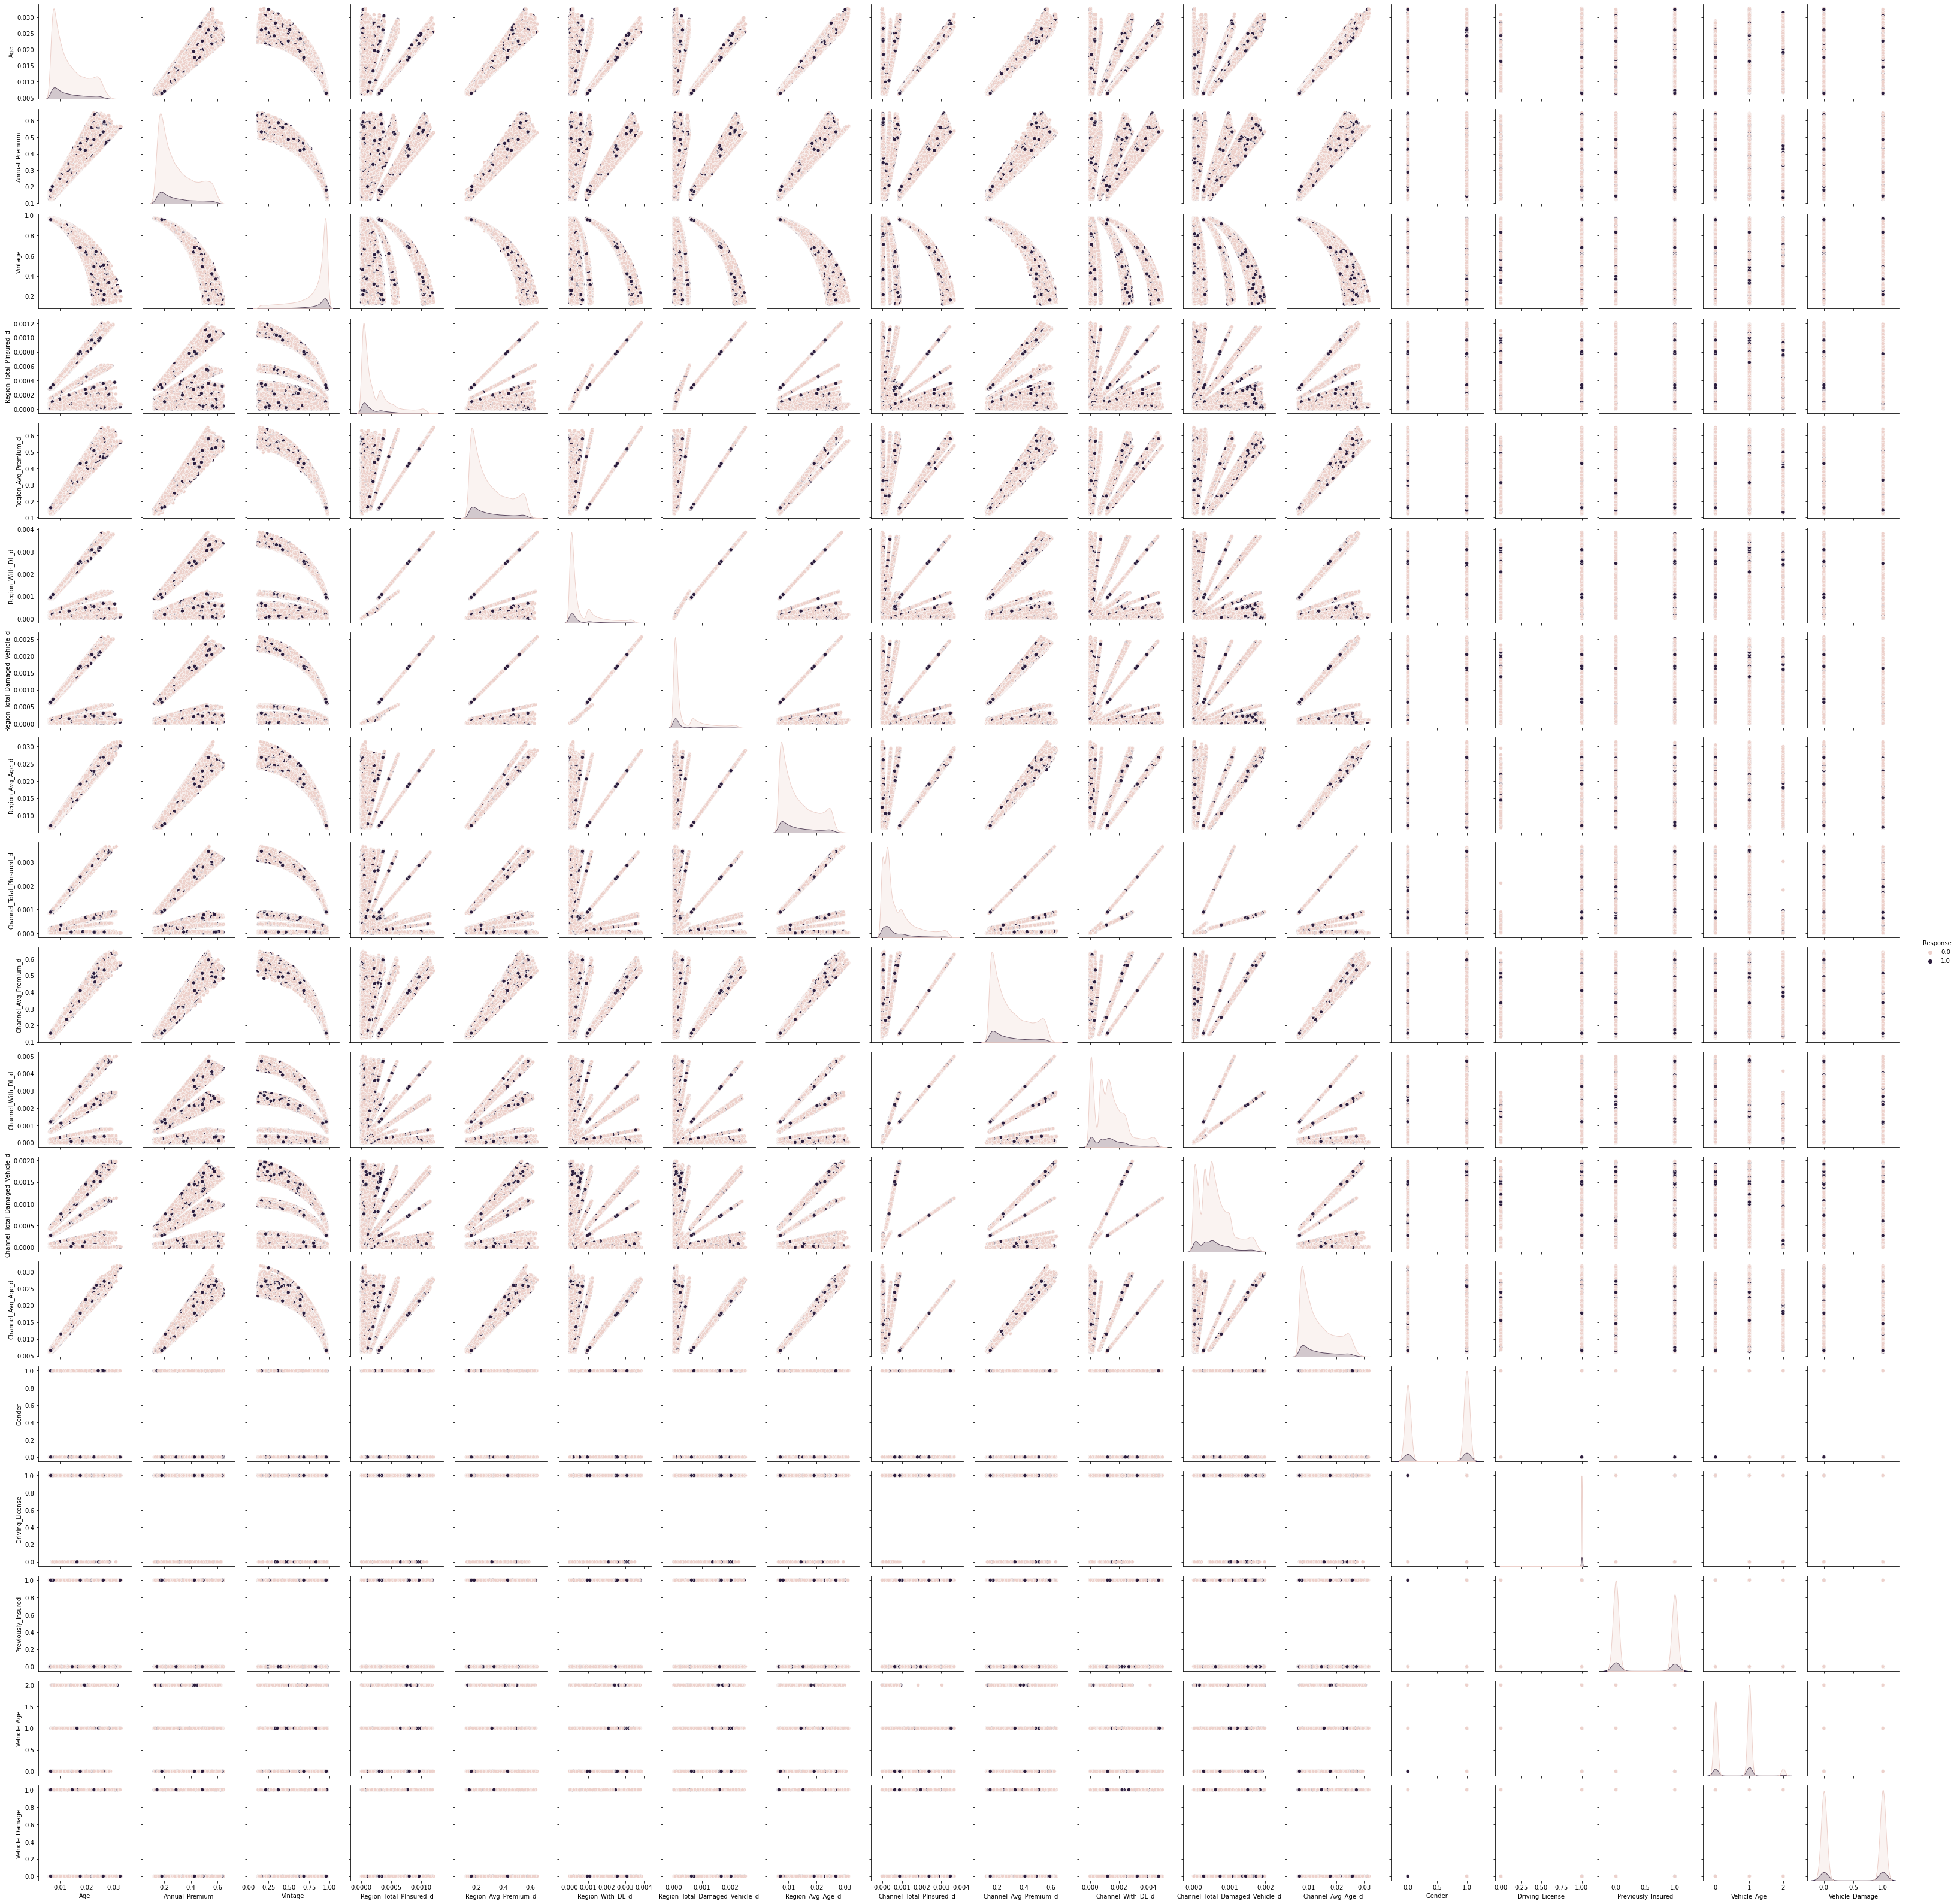

In [121]:
sns.pairplot(train_data,hue='Response')

In [122]:
X_train.head()

Age  Annual_Premium   Vintage  Region_Total_PInsured_d  \
157189  0.014818        0.341464  0.827093                 0.000079   
329529  0.011619        0.271989  0.885554                 0.000038   
63874   0.021446        0.538118  0.547150                 0.000274   
11400   0.007646        0.167848  0.960225                 0.000061   
374318  0.022403        0.521638  0.447981                 0.000975   

        Region_Avg_Premium_d  Region_With_DL_d  \
157189              0.309538          0.000142   
329529              0.264428          0.000087   
63874               0.450821          0.000485   
11400               0.155457          0.000102   
374318              0.522800          0.003116   

        Region_Total_Damaged_Vehicle_d  Region_Avg_Age_d  \
157189                        0.000059          0.014218   
329529                        0.000044          0.011862   
63874                         0.000202          0.020305   
11400                         0.000039          0.007039   
374318                        0.002063          0.023244   

        Channel_Total_PInsured_d  Channel_Avg_Premium_d  Channel_With_DL_d  \
157189                  0.000449               0.320716           0.001471   
329529                  0.001555               0.267350           0.002131   
63874                   0.000561               0.454413           0.001962   
11400                   0.000223               0.159574           0.000732   
374318                  0.000620               0.502271           0.002168   

        Channel_Total_Damaged_Vehicle_d  Channel_Avg_Age_d  Gender  \
157189                         0.000996           0.014874       1   
329529                         0.000482           0.011587       0   
63874                          0.001335           0.021151       1   
11400                          0.000496           0.007401       1   
374318                         0.001476           0.023379       1   

        Driving_License  Previously_Insured  Vehicle_Age  Vehicle_Damage  
157189                1                   0            1               1  
329529                1                   1            0               0  
63874                 1                   1            1               0  
11400                 1                   0            2               1  
374318                1                   0            0               1

## Model Building

### Baseline Decision Tree

In [123]:
clf=DTC()
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [124]:
prob_train_pred=clf.predict_proba(X_train)[:,1]
roc_auc_score(y_train,prob_train_pred)

0.9999999483200969

In [125]:
prob_val_pred=clf.predict_proba(X_val)[:,1]
roc_auc_score(y_val,prob_val_pred)

0.5982697172283648

In [126]:
clf.get_depth()

88

In [127]:
clf.get_n_leaves()

24324

In [128]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### Tune Decision Tree

In [129]:
params={'criterion':'entropy','splitter':'random','random_state':100,'max_depth':14, 'min_samples_split':35,'class_weight':{0:.1,1:.7}}

In [130]:
clf=DTC(**params)
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.1, 1: 0.7}, criterion='entropy',
                       max_depth=14, min_samples_split=35, random_state=100,
                       splitter='random')

In [131]:
prob_train_pred=clf.predict_proba(X_train)[:,1]
roc_auc_score(y_train,prob_train_pred)

0.8487835222542799

In [132]:
prob_val_pred=clf.predict_proba(X_val)[:,1]
roc_auc_score(y_val,prob_val_pred)

0.8243986652172262

#### Cross Validation

In [133]:
clf=DTC(**params)

In [134]:
skf = StratifiedKFold(n_splits=10)
roc_folds_train=[]
roc_folds_test=[]
for train_index, test_index in skf.split(X_train, y_train):
    x_train_fold, x_test_fold = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_fold, y_test_fold = y_train.iloc[train_index,:], y_train.iloc[test_index,:]
    clf.fit(x_train_fold, y_train_fold)
    pred_train=clf.predict_proba(x_train_fold)[:,1]
    pred_test=clf.predict_proba(x_test_fold)[:,1]
    roc_folds_train.append(roc_auc_score(y_train_fold,pred_train))
    roc_folds_test.append(roc_auc_score(y_test_fold,pred_test))

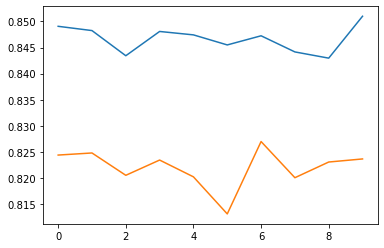

In [135]:
plt.plot(roc_folds_train,label='Train')
plt.plot(roc_folds_test,label='Test')

In [136]:
np.mean(roc_folds_train)

0.8467047956933238

In [137]:
np.mean(roc_folds_test)

0.8220484692642746

In [138]:
clf.get_n_leaves()

1274

In [139]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': {0: 0.1, 1: 0.7},
 'criterion': 'entropy',
 'max_depth': 14,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 35,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 100,
 'splitter': 'random'}

### XGBOOST

#### Baseline

In [140]:
xclf=xgbc(objective='binary:logistic',n_estimators=1400000)
xclf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='auc',early_stopping_rounds=30)

[0]	validation_0-auc:0.82675	validation_1-auc:0.82593
[1]	validation_0-auc:0.82835	validation_1-auc:0.82674
[2]	validation_0-auc:0.83120	validation_1-auc:0.82942
[3]	validation_0-auc:0.83217	validation_1-auc:0.82991
[4]	validation_0-auc:0.83498	validation_1-auc:0.83254
[5]	validation_0-auc:0.83588	validation_1-auc:0.83301
[6]	validation_0-auc:0.83645	validation_1-auc:0.83337
[7]	validation_0-auc:0.83634	validation_1-auc:0.83344
[8]	validation_0-auc:0.83757	validation_1-auc:0.83424
[9]	validation_0-auc:0.83841	validation_1-auc:0.83432
[10]	validation_0-auc:0.83917	validation_1-auc:0.83454
[11]	validation_0-auc:0.83973	validation_1-auc:0.83507
[12]	validation_0-auc:0.83998	validation_1-auc:0.83507
[13]	validation_0-auc:0.84090	validation_1-auc:0.83553
[14]	validation_0-auc:0.84329	validation_1-auc:0.83695
[15]	validation_0-auc:0.84464	validation_1-auc:0.83744
[16]	validation_0-auc:0.84513	validation_1-auc:0.83782
[17]	validation_0-auc:0.84627	validation_1-auc:0.83805
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1400000, n_jobs=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [141]:
pred_train=xclf.predict_proba(X_train)[:,1]
pred_val=xclf.predict_proba(X_val)[:,1]


In [142]:
roc_auc_score(y_train,pred_train)

0.8813063736385703

In [143]:
roc_auc_score(y_val,pred_val)

0.8429579702375136

#### CV XGB

In [235]:
params={'objective':'binary:logistic','n_estimators':1400000,'eta':.05,'max_depth':4,'scale_pos_weight':1,'subsample':.8,'colsample_bytree':.35,'reg_lambda':1.2}

In [236]:
xclf=xgbc(**params)

In [237]:
skf = StratifiedKFold(n_splits=10)
roc_Train=[]
roc_folds_train=[]
roc_folds_test=[]
roc_folds_val=[]
pred=np.zeros((len(X_val),))
pred_test_xclf=np.zeros((len(test),))
for i,(train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print("Fold : {0}".format(i))
    x_train_fold, x_test_fold = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_fold, y_test_fold = y_train.iloc[train_index,:], y_train.iloc[test_index,:]
    xclf.fit(x_train_fold,y_train_fold,eval_set=[(x_train_fold,y_train_fold),(x_test_fold,y_test_fold)],eval_metric='auc',early_stopping_rounds=10,verbose=0)
    pred_train=xclf.predict_proba(x_train_fold)[:,1]
    pred_test=xclf.predict_proba(x_test_fold)[:,1]
    pred_val=xclf.predict_proba(X_val)[:,1]
    predTrain=xclf.predict_proba(X_train)[:,1]
    pred+=pred_val
    predTest=xclf.predict_proba(test)[:,1]
    pred_test_xclf += predTest
    roc_Train.append(roc_auc_score(y_train,predTrain))
    roc_folds_train.append(roc_auc_score(y_train_fold,pred_train))
    roc_folds_test.append(roc_auc_score(y_test_fold,pred_test))
    roc_folds_val.append(roc_auc_score(y_val,pred_val))
    print("ROC-AUC | Fold : {0} | Train Fold Score  : {1}".format(i,roc_folds_train[i]))
    print("ROC-AUC | Fold : {0} | Test Fold Score  : {1}".format(i,roc_folds_test[i]))
    print("ROC-AUC | Val Score  : {1}".format(i,roc_folds_val[i]))
    print("ROC-AUC | Train Score  : {1}".format(i,roc_Train[i]))

Fold : 0
ROC-AUC | Fold : 0 | Train Fold Score  : 0.8219113925327202
ROC-AUC | Fold : 0 | Test Fold Score  : 0.8182211194775018
ROC-AUC | Val Score  : 0.8189599435262658
ROC-AUC | Train Score  : 0.8219113925327202
Fold : 1
ROC-AUC | Fold : 1 | Train Fold Score  : 0.8530343933406696
ROC-AUC | Fold : 1 | Test Fold Score  : 0.8402815536415489
ROC-AUC | Val Score  : 0.8403616476602085
ROC-AUC | Train Score  : 0.8530343933406696
Fold : 2
ROC-AUC | Fold : 2 | Train Fold Score  : 0.8294729589605998
ROC-AUC | Fold : 2 | Test Fold Score  : 0.8219550126830806
ROC-AUC | Val Score  : 0.8257003079398924
ROC-AUC | Train Score  : 0.8294729589605998
Fold : 3
ROC-AUC | Fold : 3 | Train Fold Score  : 0.8479370446354942
ROC-AUC | Fold : 3 | Test Fold Score  : 0.840706374143713
ROC-AUC | Val Score  : 0.8387981147662816
ROC-AUC | Train Score  : 0.8479370446354942
Fold : 4
ROC-AUC | Fold : 4 | Train Fold Score  : 0.8294096399705965
ROC-AUC | Fold : 4 | Test Fold Score  : 0.8275708944796354
ROC-AUC | Val Sco

In [238]:
np.mean(roc_Train)

0.8398798842165958

In [239]:
np.mean(roc_folds_train)

0.8406259517199632

In [240]:
np.mean(roc_folds_test)

0.8331574191004345

In [241]:
np.mean(roc_folds_val)

0.8328864058493547

In [242]:
pred /= 10
roc_auc_score(y_val,pred)

0.8374281248630538

In [153]:
dummy=pd.read_csv('test.csv')

In [154]:
test_prob=xclf.predict_proba(test)[:,1]

In [155]:
result={'id':dummy['id'],'Response':test_prob}

In [156]:
submission=pd.DataFrame(result)
submission.to_csv('submission.csv',index=False)

In [158]:
xclf.save_model('cross-sale.h5')

#### Light GBM

In [183]:
model=LGBMClassifier(metric='auc')
model.fit(np.asarray(X_train),np.asarray(y_train).ravel(),eval_set=[(np.asarray(X_train),np.asarray(y_train).ravel()),(np.asarray(X_val),np.asarray(y_val).ravel())],eval_names=['train','valid'],eval_metric='auc')

[1]	train's auc: 0.833953	valid's auc: 0.832417
[2]	train's auc: 0.836005	valid's auc: 0.834067
[3]	train's auc: 0.836831	valid's auc: 0.834672
[4]	train's auc: 0.837333	valid's auc: 0.835083
[5]	train's auc: 0.838037	valid's auc: 0.835512
[6]	train's auc: 0.838225	valid's auc: 0.835497
[7]	train's auc: 0.839424	valid's auc: 0.836411
[8]	train's auc: 0.839929	valid's auc: 0.836938
[9]	train's auc: 0.840807	valid's auc: 0.837392
[10]	train's auc: 0.841959	valid's auc: 0.837911
[11]	train's auc: 0.842877	valid's auc: 0.838507
[12]	train's auc: 0.84376	valid's auc: 0.838934
[13]	train's auc: 0.844293	valid's auc: 0.839458
[14]	train's auc: 0.844613	valid's auc: 0.839653
[15]	train's auc: 0.845352	valid's auc: 0.84012
[16]	train's auc: 0.8458	valid's auc: 0.840304
[17]	train's auc: 0.846375	valid's auc: 0.840405
[18]	train's auc: 0.846553	valid's auc: 0.840431
[19]	train's auc: 0.847204	valid's auc: 0.84073
[20]	train's auc: 0.848041	valid's auc: 0.841435
[21]	train's auc: 0.848236	valid's

LGBMClassifier(metric='auc')

In [168]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

#### LGBM - CV

In [251]:
params={'max_depth':3,'n_estimators':100000000,'objective':'binary','metric':'auc','random_state':100,'learning_rate':.1,'num_leaves':7,'scale_pos_weight':2,'colsample_bytree':.5}
model=LGBMClassifier(**params)

In [253]:
skf = StratifiedKFold(n_splits=10)
roc_Train=[]
roc_folds_train=[]
roc_folds_test=[]
roc_folds_val=[]
pred_lgb=np.zeros((len(X_val),))
pred_test_lgb=np.zeros((len(test),))
for i,(train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print("Fold : {0}".format(i))
    x_train_fold, x_test_fold = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_fold, y_test_fold = y_train.iloc[train_index,:], y_train.iloc[test_index,:]
    model.fit(np.asarray(x_train_fold),np.asarray(y_train_fold).ravel(),eval_set=[(np.asarray(x_train_fold),np.asarray(y_train_fold).ravel()),(np.asarray(x_test_fold),np.asarray(y_test_fold).ravel())],eval_names=['train','valid'],eval_metric='auc',early_stopping_rounds=30,verbose=0)
    pred_train=model.predict_proba(x_train_fold)[:,1]
    pred_test=model.predict_proba(x_test_fold)[:,1]
    pred_val=model.predict_proba(X_val)[:,1]
    
    predTrain=model.predict_proba(X_train)[:,1]
    pred_lgb+=pred_val
    #pred_lgb /=(i+1)
    predTest=model.predict_proba(test)[:,1]
    pred_test_lgb += predTest
    roc_Train.append(roc_auc_score(y_train,predTrain))
    roc_folds_train.append(roc_auc_score(y_train_fold,pred_train))
    roc_folds_test.append(roc_auc_score(y_test_fold,pred_test))
    roc_folds_val.append(roc_auc_score(y_val,pred_val))
    print("ROC-AUC | Fold : {0} | Train Fold Score  : {1}".format(i,roc_folds_train[i]))
    print("ROC-AUC | Fold : {0} | Test Fold Score  : {1}".format(i,roc_folds_test[i]))
    print("ROC-AUC | Val Score  : {1}".format(i,roc_folds_val[i]))
    print("ROC-AUC | Train Score  : {1}".format(i,roc_Train[i]))

Fold : 0
ROC-AUC | Fold : 0 | Train Fold Score  : 0.8674717887266106
ROC-AUC | Fold : 0 | Test Fold Score  : 0.8479729499835967
ROC-AUC | Val Score  : 0.8465870094284894
ROC-AUC | Train Score  : 0.8655391295864705
Fold : 1
ROC-AUC | Fold : 1 | Train Fold Score  : 0.8636149808574256
ROC-AUC | Fold : 1 | Test Fold Score  : 0.8493022962108401
ROC-AUC | Val Score  : 0.8465333010093068
ROC-AUC | Train Score  : 0.8621832973132469
Fold : 2
ROC-AUC | Fold : 2 | Train Fold Score  : 0.8633795347631761
ROC-AUC | Fold : 2 | Test Fold Score  : 0.8395380528246725
ROC-AUC | Val Score  : 0.8462644229515864
ROC-AUC | Train Score  : 0.8609968055550182
Fold : 3
ROC-AUC | Fold : 3 | Train Fold Score  : 0.8608301695898155
ROC-AUC | Fold : 3 | Test Fold Score  : 0.8488263403221646
ROC-AUC | Val Score  : 0.8462346305653725
ROC-AUC | Train Score  : 0.8596370884936209
Fold : 4
ROC-AUC | Fold : 4 | Train Fold Score  : 0.8596608669434805
ROC-AUC | Fold : 4 | Test Fold Score  : 0.8435553827854051
ROC-AUC | Val Sc

In [254]:
np.mean(roc_Train)

0.8595746003791029

In [255]:
np.mean(roc_folds_train)

0.8610844993570088

In [256]:
np.mean(roc_folds_test)

0.8459448450857797

In [257]:
np.mean(roc_folds_val)

0.8457981403875394

In [258]:
pred_lgb /=10
roc_auc_score(y_val,pred_lgb)

0.8469604363385543

#### Stacking Models

In [261]:
final_pred=.9*pred_lgb + .1*pred
roc_auc_score(y_val,final_pred)

0.8467766940209365

##### Final Prediction

In [262]:
final=.9*pred_test_lgb + .1*pred_test_xclf

In [263]:
result={'id':dummy['id'],'Response':final}

In [264]:
submission=pd.DataFrame(result)
submission.to_csv('submission_ensemble.csv',index=False)